Simulating room acoustics...
Volume at Left Mic  (Bright): -7.09 dB
Volume at Right Mic (Dark):   -11.92 dB


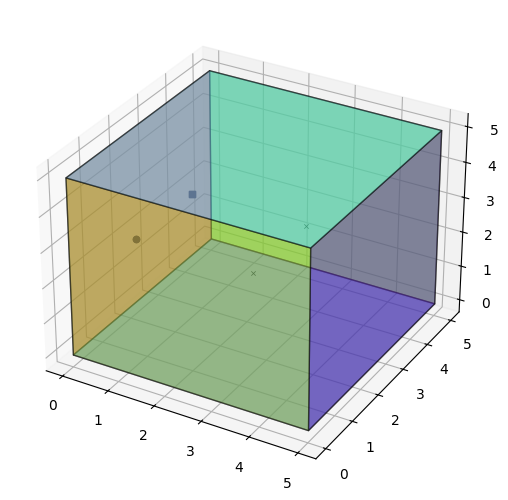

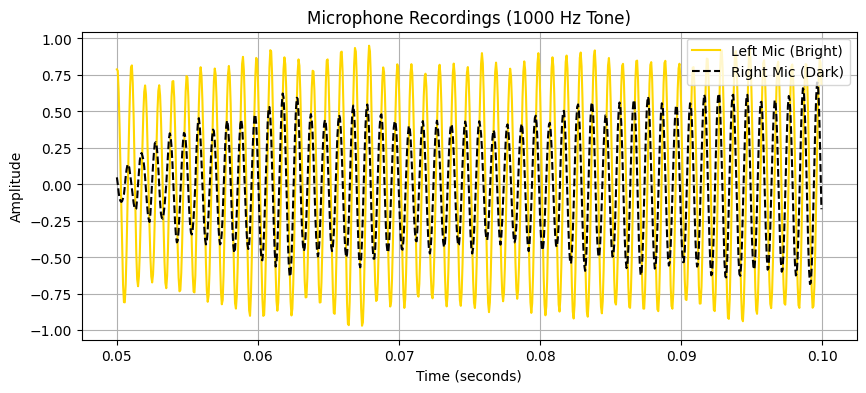

In [ ]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

# 1. Create the Room
fs = 16000
room_dim = [5, 5, 5]
room = pra.ShoeBox(room_dim, fs=fs, absorption=0.2, max_order=15)

# 2. Create the Audio Signals (1000 Hz Sine Wave for 0.1 seconds)
t = np.arange(0, 0.1, 1/fs)
f0 = 1000.0
# The Left signal is amplitude 1.0, the Right signal is amplitude 0.1
signal_loud = 1.0 * np.sin(2 * np.pi * f0 * t)
signal_quiet = 0.1 * np.sin(2 * np.pi * f0 * t)

# 3. Place the Speakers and assign their signals
# Speaker 0: Front-Left (Loud)
room.add_source([0.5, 1.5, 2.5], signal=signal_loud)
# Speaker 1: Front-Right (Quiet)
room.add_source([0.5, 3.5, 2.5], signal=signal_quiet)

# 4. Place the Microphones
# Mic 0: Mid-Left (Bright Zone target)
# Mic 1: Mid-Right (Dark Zone target)
mics = np.array([
    [3.0, 1.5, 2.5], 
    [3.0, 3.5, 2.5]
]).T
room.add_microphone_array(pra.MicrophoneArray(mics, room.fs))
room.plot()

Simulating room acoustics...
Volume at Left Mic  (Bright): -7.09 dB
Volume at Right Mic (Dark):   -11.92 dB


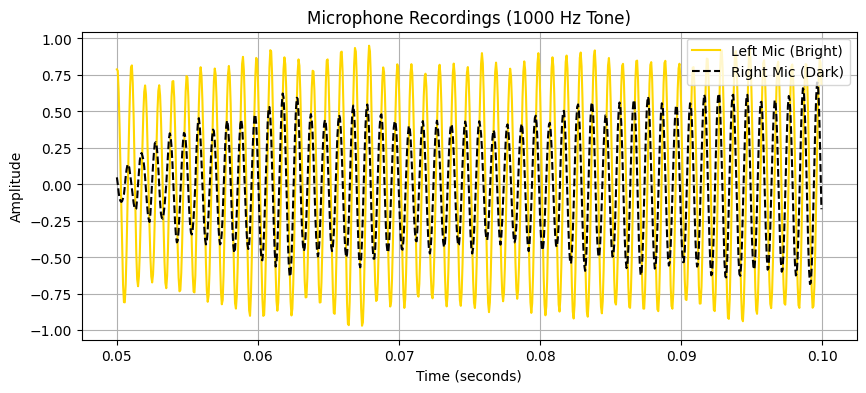

In [4]:
# 5. Run the Simulation!
# This calculates the RIRs AND convolves them with our sine waves
print("Simulating room acoustics...")
room.simulate()

# 6. Retrieve the recorded signals from the microphones
rec_left_mic = room.mic_array.signals[0, :]
rec_right_mic = room.mic_array.signals[1, :]

# Calculate the RMS (Root Mean Square) volume in Decibels
rms_left = 20 * np.log10(np.sqrt(np.mean(rec_left_mic**2)))
rms_right = 20 * np.log10(np.sqrt(np.mean(rec_right_mic**2)))

print(f"Volume at Left Mic  (Bright): {rms_left:.2f} dB")
print(f"Volume at Right Mic (Dark):   {rms_right:.2f} dB")

# 7. Plot the waveforms to literally "see" the difference
plt.figure(figsize=(10, 4))
# We only plot a small slice of time (e.g., between 0.05s and 0.06s) to see the waves clearly
start_sample = int(0.05 * fs)
end_sample = int(0.1 * fs)

plt.plot(t[start_sample:end_sample], rec_left_mic[start_sample:end_sample], label='Left Mic (Bright)', color='gold')
plt.plot(t[start_sample:end_sample], rec_right_mic[start_sample:end_sample], label='Right Mic (Dark)', color='black', linestyle='--')

plt.title("Microphone Recordings (1000 Hz Tone)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [42]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

# 1. Setup Room & Audio Signals
fs = 16000
# We use max_order=5 (fewer wall bounces) to speed up the simulation for 500 mics
room = pra.ShoeBox([5, 5, 5], fs=fs) 

t = np.arange(0, 0.1, 1/fs) # 0.1 seconds of audio
f0 = 1000.0
signal_loud = 1.0 * np.sin(2 * np.pi * f0 * t + np.pi)
signal_quiet = 1.0 * np.sin(2 * np.pi * f0 * t)

# Add Speakers (Left is loud, Right is quiet)
speakers = np.array([[0.5, 1.5, 2.5], [0.5, 3.5, 2.5]]).T
room.add_source(speakers[:, 0], signal=signal_loud)
room.add_source(speakers[:, 1], signal=signal_quiet)

# 2. Create the Microphone Grid
spacing = 0.05
x_coords = np.arange(0.2, 4.8, spacing)
y_coords = np.arange(0.2, 4.8, spacing)
X, Y = np.meshgrid(x_coords, y_coords)

# Flatten the grid to feed it into pyroomacoustics
num_mics = X.size
# mics array shape must be (3, num_mics) -> X, Y, and Z coords
mics = np.vstack((X.flatten(), Y.flatten(), np.full(num_mics, 2.5)))
room.add_microphone_array(pra.MicrophoneArray(mics, room.fs))

# 3. Run the Simulation
print(f"Simulating room with {num_mics} microphones... (This might take 2-5 seconds)")
room.simulate()



Simulating room with 8464 microphones... (This might take 2-5 seconds)


(array([9.400e+01, 1.790e+02, 1.794e+03, 4.208e+03, 1.937e+03, 2.120e+02,
        3.000e+01, 8.000e+00, 0.000e+00, 2.000e+00]),
 array([-30., -23., -16.,  -9.,  -2.,   5.,  12.,  19.,  26.,  33.,  40.]),
 <BarContainer object of 10 artists>)

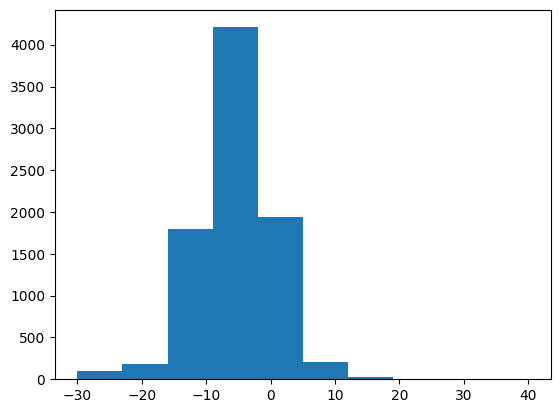

In [43]:
start_idx = int(0.08 * fs)
db_values = np.zeros(num_mics)

for i in range(num_mics):
    mic_signal = room.mic_array.signals[i, start_idx:]
    rms = np.sqrt(np.mean(mic_signal**2))
    db_values[i] = 20 * np.log10(rms + 1e-12)


plt.hist(db_values.clip(-30, 40))

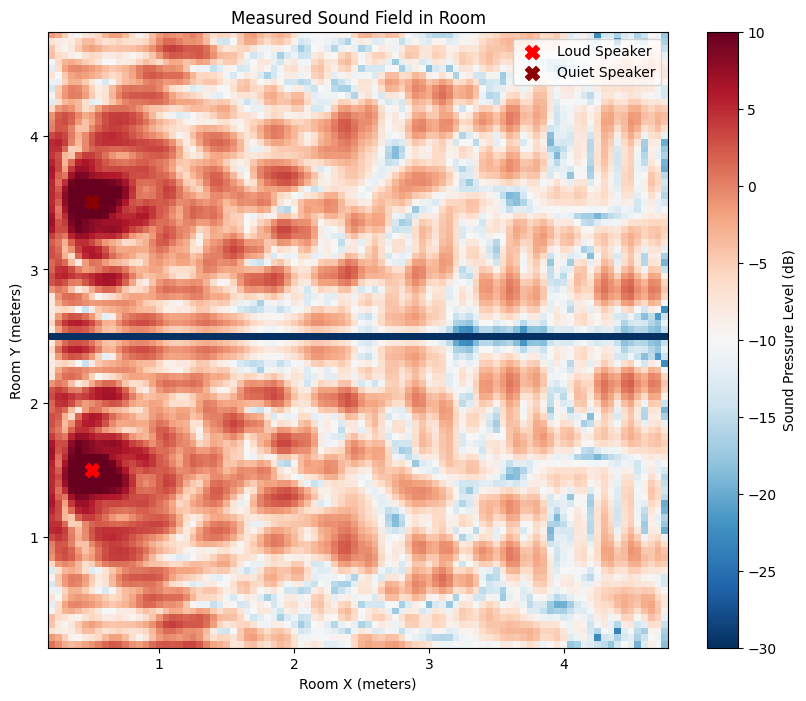

In [44]:

# Reshape the flat list of dB values back into our 2D grid shape for plotting
Z_db = db_values.reshape(X.shape)

# 5. Plot the Heat Map
plt.figure(figsize=(10, 8))
# Use pcolormesh to draw the heat map
im = plt.pcolormesh(X, Y, Z_db, cmap='RdBu_r', shading='auto', vmin=-30, vmax=10)
plt.colorbar(im, label='Sound Pressure Level (dB)')

# Plot the speakers on top
plt.scatter(speakers[0, 0], speakers[1, 0], c='red', marker='X', s=100, label='Loud Speaker')
plt.scatter(speakers[0, 1], speakers[1, 1], c='darkred', marker='X', s=100, label='Quiet Speaker')

plt.title("Measured Sound Field in Room")
plt.xlabel("Room X (meters)")
plt.ylabel("Room Y (meters)")
plt.legend(loc='upper right')
plt.show()